In [1]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

sns.set_context("paper", font_scale=1.4)

# cross-validation settings
N_SPLITS = 5
N_REPEATS = 5
SEED = 42

## Decision tree

In [3]:
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

In [4]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000,0,1,1,49,1,2,2,0,0,0,48518,49244,45385,17912,31278,14818,1800,82,1500,10000,1062,549
1,210000,1,2,2,35,0,0,0,0,0,0,209802,208421,190737,142271,137171,130687,8800,8023,4809,5001,5000,5000
2,20000,0,2,1,45,4,3,2,0,0,0,21605,20987,20200,19600,19600,20000,0,0,0,0,400,0
3,120000,1,3,1,45,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
4,350000,1,1,2,33,0,0,0,0,0,0,314994,322472,244792,140218,181571,167905,12695,9790,5302,95621,11920,6107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,120000,1,3,1,28,0,0,0,0,0,0,57863,59456,57868,60790,50091,51113,5000,3588,10000,5000,5000,3000
19996,280000,1,1,1,32,0,0,0,0,0,0,137630,116209,117118,116689,117757,118432,6000,6000,5000,5000,4012,4779
19997,420000,0,1,2,36,-1,-1,-1,2,2,2,9464,37856,31429,22483,16437,-2474,40146,23040,63,104,23,50212
19998,200000,1,1,2,27,-1,-1,-2,-2,-1,-1,134,0,0,0,101,0,0,0,0,101,0,0


In [12]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0, max_depth=3)

In [27]:
param = {
    "max_depth": 3,
}

model = DecisionTreeClassifier(**param)

# Cross-validation
cv = StratifiedKFold(n_splits=N_SPLITS)
scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()

In [28]:
auc_monit = 0.5

def objective(trial):
    global auc_monit

    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 14),
    }
    
    model = DecisionTreeClassifier(**param)

    # Cross-validation
    cv = StratifiedKFold(n_splits=N_SPLITS)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_test_auc = scores["test_score"].std()

    return mean_val_auc * 2 - 1

study = optuna.create_study(directions=["maximize"])

[I 2021-05-16 20:13:04,694] A new study created in memory with name: no-name-719d8329-3bd8-4942-ad2f-ffdc145a9765


In [29]:
study.optimize(objective, n_trials=100)

[I 2021-05-16 20:13:06,180] Trial 0 finished with value: 0.4889756120009181 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.4889756120009181.
[I 2021-05-16 20:13:07,467] Trial 1 finished with value: 0.30581302216761097 and parameters: {'max_depth': 13}. Best is trial 0 with value: 0.4889756120009181.
[I 2021-05-16 20:13:08,693] Trial 2 finished with value: 0.339480359453046 and parameters: {'max_depth': 12}. Best is trial 0 with value: 0.4889756120009181.
[I 2021-05-16 20:13:10,044] Trial 3 finished with value: 0.2729927708786539 and parameters: {'max_depth': 14}. Best is trial 0 with value: 0.4889756120009181.
[I 2021-05-16 20:13:10,740] Trial 4 finished with value: 0.5014127104088844 and parameters: {'max_depth': 6}. Best is trial 4 with value: 0.5014127104088844.
[I 2021-05-16 20:13:11,793] Trial 5 finished with value: 0.41039766315994775 and parameters: {'max_depth': 10}. Best is trial 4 with value: 0.5014127104088844.
[I 2021-05-16 20:13:12,205] Trial 6 finished wi

In [30]:
study.best_params

{'max_depth': 5}

In [31]:
model = DecisionTreeClassifier(**study.best_params)

In [32]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()

# Test
model.fit(X = X_train, y = np.ravel(y_train))
preds = model.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

In [33]:
# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_test_auc * 2 - 1, 4), f"({np.round(std_test_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")

mean_train_GINI:	 0.5296
mean_dev_GINI:		 0.5013 (0.009)
test_GINI:		 0.5119


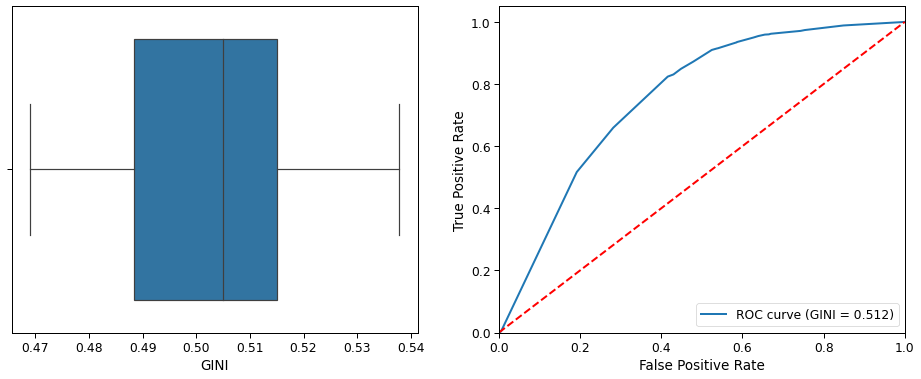

In [34]:
# boxplot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
fig1 = sns.boxplot(scores["test_score"]*2-1, ax=axs[0])
fig1.set_xlabel('GINI')

# RoC
preds = model.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw=2
axs[1].plot(fpr, tpr, lw=lw, label='ROC curve (GINI = %0.3f)' % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.savefig('Img\lr_cv_roc.png', facecolor='w')